##  1.环境设置和数据下载

In [2]:
# =============================================================================
# 第1段：环境设置和导入
# =============================================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# PyTorch相关
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# 机器学习指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# 设置随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 检查GPU可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU型号: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# 创建必要的目录
os.makedirs('./data', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./logs', exist_ok=True)
os.makedirs('./results', exist_ok=True)

print("✅ 环境设置完成")

使用设备: cuda
GPU型号: Tesla T4
GPU内存: 14.7 GB
✅ 环境设置完成


##  2.数据下载与预处理


In [3]:
# =============================================================================
# 第2段：数据下载和预处理
# =============================================================================

# 检查是否在Kaggle环境中
IS_KAGGLE = os.path.exists('/kaggle')

if IS_KAGGLE:
    # Kaggle环境中的数据路径
    BASE_DATA_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23'
    print("检测到Kaggle环境")
    print(f"数据基础路径: {BASE_DATA_DIR}")
else:
    # 本地环境
    BASE_DATA_DIR = './FaceForensics++_C23'
    print("本地环境")

# 视频帧提取函数
def extract_frames_from_video(video_path, max_frames=30, target_size=(128, 128)):
    """
    从视频中提取帧
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return frames
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        cap.release()
        return frames
    
    # 计算采样间隔
    if total_frames <= max_frames:
        frame_indices = list(range(total_frames))
    else:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            # 转换颜色空间
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # 调整大小
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
    
    cap.release()
    return frames

# 处理所有视频
def process_videos(base_data_dir, max_videos_per_class=50, max_frames=30):
    """
    处理所有视频并创建数据集
    """
    data_list = []
    
    # 定义类别映射：original为真实视频，其他为伪造视频
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']
    
    # 处理真实视频 (original)
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        print(f"处理真实视频目录: {original_dir}")
        video_files = [f for f in os.listdir(original_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
        
        # 限制视频数量
        if len(video_files) > max_videos_per_class:
            video_files = random.sample(video_files, max_videos_per_class)
        
        print(f"找到 {len(video_files)} 个真实视频")
        
        for video_file in tqdm(video_files, desc="处理真实视频"):
            video_path = os.path.join(original_dir, video_file)
            
            # 提取帧
            frames = extract_frames_from_video(video_path, max_frames)
            
            if len(frames) > 0:
                # 保存帧数据路径
                frame_save_dir = os.path.join('./data', 'frames', 'real')
                os.makedirs(frame_save_dir, exist_ok=True)
                
                video_name = os.path.splitext(video_file)[0]
                frame_save_path = os.path.join(frame_save_dir, f"{video_name}.npy")
                
                # 保存帧数据
                np.save(frame_save_path, np.array(frames))
                
                data_list.append({
                    'video_path': video_path,
                    'frame_path': frame_save_path,
                    'label': 0,  # 真实视频标签为0
                    'category': 'real',
                    'method': 'original',
                    'num_frames': len(frames)
                })
    
    # 处理伪造视频
    fake_count = 0
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            print(f"处理伪造视频目录: {method_dir}")
            video_files = [f for f in os.listdir(method_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
            
            # 限制每种方法的视频数量
            method_limit = max_videos_per_class // len(fake_methods)
            if len(video_files) > method_limit:
                video_files = random.sample(video_files, method_limit)
            
            print(f"找到 {len(video_files)} 个 {method} 伪造视频")
            
            for video_file in tqdm(video_files, desc=f"处理{method}视频"):
                video_path = os.path.join(method_dir, video_file)
                
                # 提取帧
                frames = extract_frames_from_video(video_path, max_frames)
                
                if len(frames) > 0:
                    # 保存帧数据路径
                    frame_save_dir = os.path.join('./data', 'frames', 'fake')
                    os.makedirs(frame_save_dir, exist_ok=True)
                    
                    video_name = os.path.splitext(video_file)[0]
                    frame_save_path = os.path.join(frame_save_dir, f"{method}_{video_name}.npy")
                    
                    # 保存帧数据
                    np.save(frame_save_path, np.array(frames))
                    
                    data_list.append({
                        'video_path': video_path,
                        'frame_path': frame_save_path,
                        'label': 1,  # 伪造视频标签为1
                        'category': 'fake',
                        'method': method,
                        'num_frames': len(frames)
                    })
                    
                    fake_count += 1
    
    print(f"总共处理了 {len(data_list)} 个视频")
    print(f"真实视频: {len([d for d in data_list if d['label'] == 0])} 个")
    print(f"伪造视频: {len([d for d in data_list if d['label'] == 1])} 个")
    
    return data_list

# 检查数据目录结构
if IS_KAGGLE:
    print("检查数据目录结构:")
    if os.path.exists(BASE_DATA_DIR):
        subdirs = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]
        print(f"找到子目录: {subdirs}")
        
        # 检查每个子目录的视频数量
        for subdir in subdirs:
            subdir_path = os.path.join(BASE_DATA_DIR, subdir)
            video_files = [f for f in os.listdir(subdir_path) if f.endswith(('.mp4', '.avi', '.mov'))]
            print(f"  {subdir}: {len(video_files)} 个视频文件")
    else:
        print(f"❌ 基础数据目录不存在: {BASE_DATA_DIR}")

# 检查是否已有预处理数据
if os.path.exists('./data/train.csv') and os.path.exists('./data/val.csv'):
    print("✅ 发现已有预处理数据")
    train_df = pd.read_csv('./data/train.csv')
    val_df = pd.read_csv('./data/val.csv')
    print(f"训练集: {len(train_df)} 个样本")
    print(f"验证集: {len(val_df)} 个样本")
else:
    print("开始处理视频数据...")
    # 处理视频
    data_list = process_videos(BASE_DATA_DIR, max_videos_per_class=100, max_frames=30)
    
    if len(data_list) == 0:
        print("❌ 没有找到有效的视频数据")
        print("请检查数据路径和文件格式")
    else:
        # 创建DataFrame
        df = pd.DataFrame(data_list)
        
        # 显示数据分布
        print("\n数据分布:")
        print(df['category'].value_counts())
        if 'method' in df.columns:
            print("\n各方法分布:")
            print(df['method'].value_counts())
        
        # 划分训练集和验证集
        from sklearn.model_selection import train_test_split
        
        train_df, val_df = train_test_split(
            df, test_size=0.2, random_state=42, stratify=df['label']
        )
        
        # 保存CSV文件
        train_df.to_csv('./data/train.csv', index=False)
        val_df.to_csv('./data/val.csv', index=False)
        
        print(f"\n✅ 数据处理完成")
        print(f"训练集: {len(train_df)} 个样本")
        print(f"验证集: {len(val_df)} 个样本")
        print(f"真实视频: {len(df[df['label']==0])} 个")
        print(f"伪造视频: {len(df[df['label']==1])} 个")

检测到Kaggle环境
数据基础路径: /kaggle/input/ff-c23/FaceForensics++_C23
检查数据目录结构:
找到子目录: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
  Face2Face: 1000 个视频文件
  csv: 0 个视频文件
  Deepfakes: 1000 个视频文件
  DeepFakeDetection: 1000 个视频文件
  original: 1000 个视频文件
  NeuralTextures: 1000 个视频文件
  FaceShifter: 1000 个视频文件
  FaceSwap: 1000 个视频文件
开始处理视频数据...
处理真实视频目录: /kaggle/input/ff-c23/FaceForensics++_C23/original
找到 100 个真实视频


处理真实视频: 100%|██████████| 100/100 [10:04<00:00,  6.05s/it]


处理伪造视频目录: /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes
找到 20 个 Deepfakes 伪造视频


处理Deepfakes视频: 100%|██████████| 20/20 [02:00<00:00,  6.02s/it]


处理伪造视频目录: /kaggle/input/ff-c23/FaceForensics++_C23/Face2Face
找到 20 个 Face2Face 伪造视频


处理Face2Face视频: 100%|██████████| 20/20 [02:20<00:00,  7.02s/it]


处理伪造视频目录: /kaggle/input/ff-c23/FaceForensics++_C23/FaceShifter
找到 20 个 FaceShifter 伪造视频


处理FaceShifter视频: 100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


处理伪造视频目录: /kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap
找到 20 个 FaceSwap 伪造视频


处理FaceSwap视频: 100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


处理伪造视频目录: /kaggle/input/ff-c23/FaceForensics++_C23/NeuralTextures
找到 20 个 NeuralTextures 伪造视频


处理NeuralTextures视频: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]

总共处理了 200 个视频
真实视频: 100 个
伪造视频: 100 个

数据分布:
category
real    100
fake    100
Name: count, dtype: int64

各方法分布:
method
original          100
Deepfakes          20
Face2Face          20
FaceShifter        20
FaceSwap           20
NeuralTextures     20
Name: count, dtype: int64

✅ 数据处理完成
训练集: 160 个样本
验证集: 40 个样本
真实视频: 100 个
伪造视频: 100 个


## 3.数据集类定义 

In [5]:
# =============================================================================
# 第3段：数据集类定义
# =============================================================================

class DeepfakeVideoDataset(Dataset):
    def __init__(self, csv_file, transform=None, max_frames=30):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.max_frames = max_frames
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # 加载帧数据
        frames = np.load(row['frame_path'])
        label = row['label']
        
        # 确保帧数量
        if len(frames) < self.max_frames:
            # 如果帧数不足，重复最后一帧
            last_frame = frames[-1]
            padding = np.repeat(last_frame[np.newaxis, :], self.max_frames - len(frames), axis=0)
            frames = np.concatenate([frames, padding], axis=0)
        elif len(frames) > self.max_frames:
            # 如果帧数过多，均匀采样
            indices = np.linspace(0, len(frames)-1, self.max_frames, dtype=int)
            frames = frames[indices]
        
        # 应用变换
        if self.transform:
            transformed_frames = []
            for frame in frames:
                transformed_frame = self.transform(frame)
                transformed_frames.append(transformed_frame)
            frames = torch.stack(transformed_frames)
        else:
            frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
        
        return frames, torch.tensor(label, dtype=torch.float32)

# 数据转换
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ 数据集类定义完成")

✅ 数据集类定义完成


## 4.模型定义

In [6]:
# =============================================================================
# 第4段：模型定义
# =============================================================================

# CNN特征提取器
class CNNFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(CNNFeatureExtractor, self).__init__()
        # 使用ResNet18作为特征提取器
        self.backbone = models.resnet18(pretrained=pretrained)
        # 移除最后的分类层
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.feature_dim = 512
    
    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # 展平
        return features

# 注意力层
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, hidden_dim)
        attention_weights = torch.softmax(self.attention(x), dim=1)
        # 加权求和
        attended = torch.sum(attention_weights * x, dim=1)
        return attended, attention_weights

# 标准深度伪造检测模型
class DeepfakeDetector(nn.Module):
    def __init__(self, num_classes=1, hidden_dim=256, num_layers=2, dropout=0.3):
        super(DeepfakeDetector, self).__init__()
        
        # CNN特征提取器
        self.cnn = CNNFeatureExtractor(pretrained=True)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=self.cnn.feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # 注意力层
        self.attention = AttentionLayer(hidden_dim * 2)  # 双向LSTM
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        
        # 重塑为(batch_size * seq_len, channels, height, width)
        x = x.view(batch_size * seq_len, channels, height, width)
        
        # CNN特征提取
        features = self.cnn(x)  # (batch_size * seq_len, feature_dim)
        
        # 重塑为(batch_size, seq_len, feature_dim)
        features = features.view(batch_size, seq_len, -1)
        
        # LSTM处理
        lstm_out, _ = self.lstm(features)  # (batch_size, seq_len, hidden_dim * 2)
        
        # 注意力机制
        attended, attention_weights = self.attention(lstm_out)
        
        # 分类
        output = self.classifier(attended)
        
        return output.squeeze(), attention_weights

# 轻量级深度伪造检测模型
class LightweightDeepfakeDetector(nn.Module):
    def __init__(self, num_classes=1, hidden_dim=128, dropout=0.3):
        super(LightweightDeepfakeDetector, self).__init__()
        
        # 使用MobileNetV2作为特征提取器
        self.backbone = models.mobilenet_v2(pretrained=True)
        self.backbone.classifier = nn.Identity()  # 移除分类层
        self.feature_dim = 1280
        
        # GRU层（比LSTM更轻量）
        self.gru = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # 注意力层
        self.attention = AttentionLayer(hidden_dim * 2)
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        
        # 重塑为(batch_size * seq_len, channels, height, width)
        x = x.view(batch_size * seq_len, channels, height, width)
        
        # CNN特征提取
        features = self.backbone(x)  # (batch_size * seq_len, feature_dim)
        
        # 重塑为(batch_size, seq_len, feature_dim)
        features = features.view(batch_size, seq_len, -1)
        
        # GRU处理
        gru_out, _ = self.gru(features)  # (batch_size, seq_len, hidden_dim * 2)
        
        # 注意力机制
        attended, attention_weights = self.attention(gru_out)
        
        # 分类
        output = self.classifier(attended)
        
        return output.squeeze(), attention_weights

# 模型创建函数
def create_model(model_type='standard', device='cpu'):
    if model_type == 'standard':
        model = DeepfakeDetector()
    elif model_type == 'lightweight':
        model = LightweightDeepfakeDetector()
    else:
        raise ValueError(f"不支持的模型类型: {model_type}")
    
    return model.to(device)

print("✅ 模型定义完成")

✅ 模型定义完成


## 5.训练和验证函数

In [7]:
# =============================================================================
# 第5段：训练和验证函数
# =============================================================================

# 训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    
    progress_bar = tqdm(train_loader, desc='训练')
    
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        if isinstance(model.forward(inputs), tuple):
            outputs, _ = model(inputs)
        else:
            outputs = model(inputs)
        
        outputs = outputs.squeeze()
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # 优化
        optimizer.step()
        
        # 统计
        running_loss += loss.item() * inputs.size(0)
        
        # 收集预测和目标
        preds = (outputs > 0.5).float().cpu().numpy()
        all_predictions.extend(preds)
        all_targets.extend(labels.cpu().numpy())
        
        # 更新进度条
        progress_bar.set_postfix({'loss': loss.item()})
    
    # 计算平均损失和指标
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, zero_division=0)
    recall = recall_score(all_targets, all_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, zero_division=0)
    
    return epoch_loss, accuracy, precision, recall, f1

# 验证函数
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='验证')
        
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 前向传播
            if isinstance(model.forward(inputs), tuple):
                outputs, _ = model(inputs)
            else:
                outputs = model(inputs)
            
            outputs = outputs.squeeze()
            
            # 计算损失
            loss = criterion(outputs, labels)
            
            # 统计
            running_loss += loss.item() * inputs.size(0)
            
            # 收集预测和目标
            preds = (outputs > 0.5).float().cpu().numpy()
            all_predictions.extend(preds)
            all_targets.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())
            
            # 更新进度条
            progress_bar.set_postfix({'loss': loss.item()})
    
    # 计算平均损失和指标
    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, zero_division=0)
    recall = recall_score(all_targets, all_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, zero_division=0)
    auc_score = roc_auc_score(all_targets, all_scores) if len(set(all_targets)) > 1 else 0.0
    
    return epoch_loss, accuracy, precision, recall, f1, auc_score

# 保存检查点函数
def save_checkpoint(model, optimizer, epoch, metrics, save_dir, model_type, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics
    }
    
    # 保存最新检查点
    latest_path = os.path.join(save_dir, f'{model_type}_model_latest.pth')
    torch.save(checkpoint, latest_path)
    
    # 如果是最佳模型，保存最佳检查点
    if is_best:
        best_path = os.path.join(save_dir, f'{model_type}_model_best.pth')
        torch.save(checkpoint, best_path)

# 绘制训练曲线函数
def plot_training_curves(train_losses, val_losses, train_metrics, val_metrics, save_dir):
    epochs = range(1, len(train_losses) + 1)
    
    # 创建子图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 损失曲线
    axes[0, 0].plot(epochs, train_losses, 'b-', label='训练损失')
    axes[0, 0].plot(epochs, val_losses, 'r-', label='验证损失')
    axes[0, 0].set_title('损失曲线')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('损失')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # 准确率曲线
    train_acc = [m['accuracy'] for m in train_metrics]
    val_acc = [m['accuracy'] for m in val_metrics]
    axes[0, 1].plot(epochs, train_acc, 'b-', label='训练准确率')
    axes[0, 1].plot(epochs, val_acc, 'r-', label='验证准确率')
    axes[0, 1].set_title('准确率曲线')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('准确率')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # F1分数曲线
    train_f1 = [m['f1'] for m in train_metrics]
    val_f1 = [m['f1'] for m in val_metrics]
    axes[1, 0].plot(epochs, train_f1, 'b-', label='训练F1')
    axes[1, 0].plot(epochs, val_f1, 'r-', label='验证F1')
    axes[1, 0].set_title('F1分数曲线')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1分数')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # AUC曲线
    val_auc = [m.get('auc', 0) for m in val_metrics]
    axes[1, 1].plot(epochs, val_auc, 'r-', label='验证AUC')
    axes[1, 1].set_title('AUC曲线')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.close()

print("✅ 训练和验证函数定义完成")

✅ 训练和验证函数定义完成


##  6.模型训练

In [8]:
# =============================================================================
# 第6段：模型训练
# =============================================================================

# 训练参数
MODEL_TYPE = 'lightweight'  # 'standard' 或 'lightweight'
NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-5
NUM_FRAMES = 30

print(f"训练参数:")
print(f"- 模型类型: {MODEL_TYPE}")
print(f"- 训练轮数: {NUM_EPOCHS}")
print(f"- 批量大小: {BATCH_SIZE}")
print(f"- 学习率: {LEARNING_RATE}")
print(f"- 权重衰减: {WEIGHT_DECAY}")
print(f"- 帧数: {NUM_FRAMES}")

# 创建数据集
train_dataset = DeepfakeVideoDataset(
    csv_file='./data/train.csv',
    transform=transform,
    max_frames=NUM_FRAMES
)

val_dataset = DeepfakeVideoDataset(
    csv_file='./data/val.csv',
    transform=transform,
    max_frames=NUM_FRAMES
)

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")

# 创建模型
model = create_model(model_type=MODEL_TYPE, device=device)
print(f"模型类型: {MODEL_TYPE}")

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# 初始化变量
start_epoch = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_metrics = []
val_metrics = []

print("✅ 训练准备完成")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


训练参数:
- 模型类型: lightweight
- 训练轮数: 10
- 批量大小: 8
- 学习率: 0.0001
- 权重衰减: 1e-05
- 帧数: 30
训练集大小: 160
验证集大小: 40


100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 


模型类型: lightweight
✅ 训练准备完成


## 7.执行训练循环

In [9]:
# =============================================================================
# 第7段：执行训练循环
# =============================================================================

# 训练循环
print("开始训练...")
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # 训练
    train_loss, train_acc, train_prec, train_rec, train_f1 = train(
        model, train_loader, criterion, optimizer, device
    )
    
    # 验证
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = validate(
        model, val_loader, criterion, device
    )
    
    # 更新学习率
    scheduler.step(val_loss)
    
    # 记录指标
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_metrics.append({
        'accuracy': train_acc,
        'precision': train_prec,
        'recall': train_rec,
        'f1': train_f1
    })
    
    val_metrics.append({
        'accuracy': val_acc,
        'precision': val_prec,
        'recall': val_rec,
        'f1': val_f1,
        'auc': val_auc
    })
    
    # 打印指标
    print(f"训练损失: {train_loss:.4f}, 准确率: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"验证损失: {val_loss:.4f}, 准确率: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
    
    # 检查是否是最佳模型
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        print("🎉 发现更好的模型！")
    
    # 保存检查点
    metrics = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_f1': train_f1,
        'val_f1': val_f1,
        'val_auc': val_auc
    }
    save_checkpoint(model, optimizer, epoch, metrics, './models', MODEL_TYPE, is_best)
    
    # 绘制训练曲线
    plot_training_curves(train_losses, val_losses, train_metrics, val_metrics, './logs')

print("✅ 训练完成！")

开始训练...

Epoch 1/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s, loss=0.69] 


训练损失: 0.7090, 准确率: 0.4500, F1: 0.3889
验证损失: 0.7024, 准确率: 0.4250, F1: 0.4889, AUC: 0.4475
🎉 发现更好的模型！

Epoch 2/10


验证: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s, loss=0.715]


训练损失: 0.6197, 准确率: 0.7438, F1: 0.7515
验证损失: 0.7132, 准确率: 0.4250, F1: 0.4889, AUC: 0.5125

Epoch 3/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s, loss=0.777]


训练损失: 0.5012, 准确率: 0.8562, F1: 0.8535
验证损失: 0.7645, 准确率: 0.5000, F1: 0.6000, AUC: 0.5425

Epoch 4/10


验证: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s, loss=0.654]


训练损失: 0.3421, 准确率: 0.9125, F1: 0.9067
验证损失: 0.9342, 准确率: 0.5000, F1: 0.5238, AUC: 0.5250

Epoch 5/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s, loss=0.962]


训练损失: 0.1882, 准确率: 0.9375, F1: 0.9351
验证损失: 1.0310, 准确率: 0.5750, F1: 0.6383, AUC: 0.5225

Epoch 6/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s, loss=1.01] 


训练损失: 0.1529, 准确率: 0.9500, F1: 0.9512
验证损失: 1.1862, 准确率: 0.5500, F1: 0.6250, AUC: 0.5325

Epoch 7/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s, loss=1.37] 


训练损失: 0.1004, 准确率: 0.9750, F1: 0.9756
验证损失: 1.2477, 准确率: 0.5750, F1: 0.6383, AUC: 0.5300

Epoch 8/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s, loss=0.858]


训练损失: 0.1715, 准确率: 0.9375, F1: 0.9359
验证损失: 1.4276, 准确率: 0.5250, F1: 0.5366, AUC: 0.5375

Epoch 9/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s, loss=1.59] 


训练损失: 0.0704, 准确率: 0.9750, F1: 0.9747
验证损失: 1.5214, 准确率: 0.5500, F1: 0.6250, AUC: 0.5125

Epoch 10/10


验证: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s, loss=1.17] 


训练损失: 0.0327, 准确率: 0.9938, F1: 0.9937
验证损失: 1.5551, 准确率: 0.5750, F1: 0.6222, AUC: 0.5200
✅ 训练完成！


## 8.模型评估

In [10]:
# =============================================================================
# 第8段：模型评估
# =============================================================================

# 评估函数
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='评估')
        
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            # 前向传播
            if isinstance(model.forward(inputs), tuple):
                outputs, _ = model(inputs)
            else:
                outputs = model(inputs)
            
            outputs = outputs.squeeze()
            
            # 计算损失
            loss = criterion(outputs, labels)
            
            # 统计
            running_loss += loss.item() * inputs.size(0)
            
            # 收集预测和目标
            preds = (outputs > 0.5).float().cpu().numpy()
            all_predictions.extend(preds)
            all_targets.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())
            
            # 更新进度条
            progress_bar.set_postfix({'loss': loss.item()})
    
    # 计算平均损失
    test_loss = running_loss / len(test_loader.dataset)
    
    return test_loss, all_predictions, all_targets, all_scores

# 计算并打印指标
def calculate_metrics(predictions, targets, scores):
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions, zero_division=0)
    f1 = f1_score(targets, predictions, zero_division=0)
    auc_score = roc_auc_score(targets, scores) if len(set(targets)) > 1 else 0.0
    
    print(f"准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    # 打印分类报告
    print("\n分类报告:")
    print(classification_report(targets, predictions, target_names=['真实', '伪造']))
    
    # 计算混淆矩阵
    cm = confusion_matrix(targets, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm
    }

# 绘制混淆矩阵
def plot_confusion_matrix(cm, save_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['真实', '伪造'], yticklabels=['真实', '伪造'])
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title('混淆矩阵')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

# 绘制ROC曲线
def plot_roc_curve(targets, scores, save_path):
    fpr, tpr, _ = roc_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲线 (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假阳性率')
    plt.ylabel('真阳性率')
    plt.title('接收者操作特征曲线')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

print("✅ 评估函数定义完成")

✅ 评估函数定义完成


## 9.执行模型评估

✅ 加载最佳模型: ./models/lightweight_model_best.pth
测试集大小: 40
开始评估...


评估: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s, loss=0.69] 


测试损失: 0.7024
准确率: 0.4250
精确率: 0.4400
召回率: 0.5500
F1分数: 0.4889
AUC-ROC: 0.4475

分类报告:
              precision    recall  f1-score   support

          真实       0.40      0.30      0.34        20
          伪造       0.44      0.55      0.49        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40



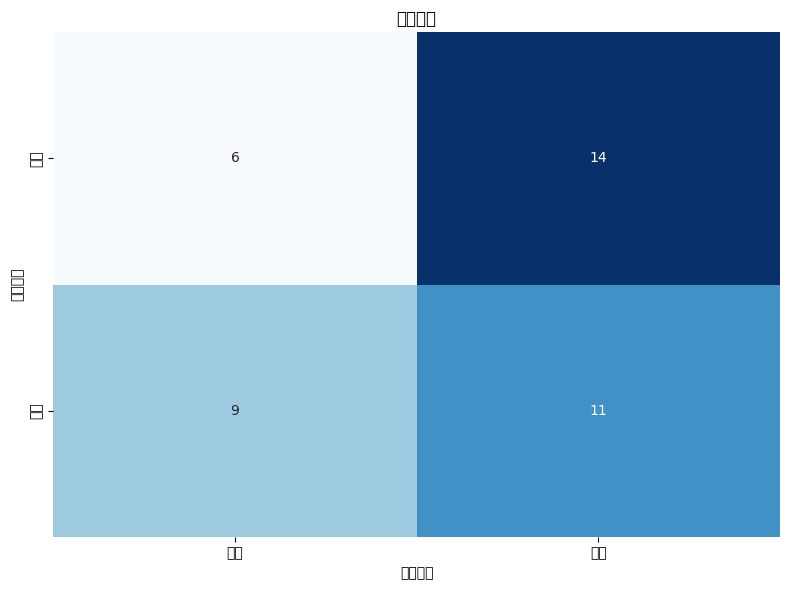

✅ 混淆矩阵已保存到 ./results/confusion_matrix.png


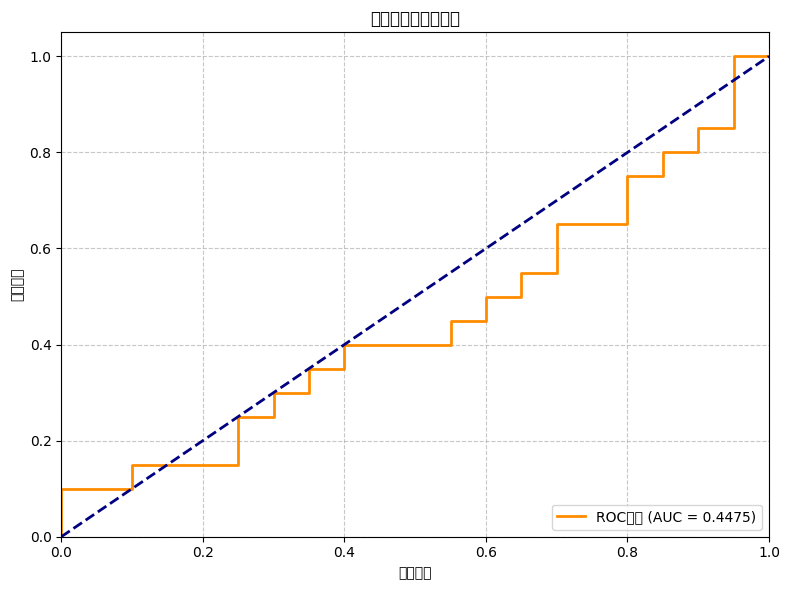

✅ ROC曲线已保存到 ./results/roc_curve.png
✅ 评估结果已保存到 ./results/evaluation_results.csv

🎉 评估完成！
最终结果: 准确率=0.4250, F1=0.4889, AUC=0.4475


In [12]:
# =============================================================================
# 第9段：执行模型评估
# =============================================================================

# 加载最佳模型
best_model_path = os.path.join('./models', f'{MODEL_TYPE}_model_best.pth')
if os.path.exists(best_model_path):
    # 修复：添加 weights_only=False 参数
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ 加载最佳模型: {best_model_path}")
else:
    print("⚠️ 未找到最佳模型，使用当前模型")

# 创建测试数据加载器（使用验证集作为测试集）
test_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"测试集大小: {len(val_dataset)}")

# 评估模型
print("开始评估...")
test_loss, predictions, targets, scores = evaluate_model(model, test_loader, criterion, device)
print(f"测试损失: {test_loss:.4f}")

# 计算指标
metrics = calculate_metrics(predictions, targets, scores)

# 绘制混淆矩阵
cm_path = os.path.join('./results', 'confusion_matrix.png')
plot_confusion_matrix(metrics['confusion_matrix'], cm_path)
print(f"✅ 混淆矩阵已保存到 {cm_path}")

# 绘制ROC曲线
roc_path = os.path.join('./results', 'roc_curve.png')
plot_roc_curve(targets, scores, roc_path)
print(f"✅ ROC曲线已保存到 {roc_path}")

# 保存评估结果
results = {
    'test_loss': test_loss,
    'accuracy': metrics['accuracy'],
    'precision': metrics['precision'],
    'recall': metrics['recall'],
    'f1': metrics['f1'],
    'auc': metrics['auc']
}

results_df = pd.DataFrame([results])
results_df.to_csv(os.path.join('./results', 'evaluation_results.csv'), index=False)
print(f"✅ 评估结果已保存到 ./results/evaluation_results.csv")

print("\n🎉 评估完成！")
print(f"最终结果: 准确率={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")